In [1]:
import pandas as pd
import random
import json
import ast
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df = pd.read_csv('../data/dataset_churn_challenge.csv')
df_zonas = pd.read_csv('../data/dataset_churn_zona_challenge.csv')

C:\Users\Ithreex Global\AppData\Local\Temp\ipykernel_2140\3294815120.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/dataset_churn_challenge.csv')


In [3]:
def predecir_churn(tipo_asistencia):
    tipo_asistencia = str(tipo_asistencia)
    if tipo_asistencia.lower() == 'problema':
        return 1.0  # Siempre devuelve 1 si es un problema
    elif tipo_asistencia.lower() == 'reclamo':
        return 0.8 if random.random() < 0.5 else 0  # 50% de probabilidad para reclamos
    else:
        return 0

In [4]:
# Mostrar todo el contenido de las celdas sin cortar
pd.set_option("display.max_colwidth", None)

In [5]:
import pandas as pd
import ast
import json
import numpy as np

def punto_en_poligono(punto_lat, punto_lon, poligono_coords):
    """
    Determina si un punto está dentro de un polígono usando el algoritmo ray casting
    
    Parámetros:
    - punto_lat, punto_lon: coordenadas del punto a verificar
    - poligono_coords: lista de tuplas (lon, lat) que definen el polígono
    
    Retorna:
    - True si el punto está dentro del polígono, False si no
    """
    x, y = punto_lon, punto_lat  # Punto a verificar (x=longitud, y=latitud)
    n = len(poligono_coords)
    dentro = False
    
    # Asegurar que tenemos al menos 3 puntos para formar un polígono
    if n < 3:
        return False
    
    j = n - 1  # Último índice
    
    for i in range(n):
        xi, yi = poligono_coords[i][0], poligono_coords[i][1]  # poligono_coords[i] = (lon, lat)
        xj, yj = poligono_coords[j][0], poligono_coords[j][1]  # poligono_coords[j] = (lon, lat)
        
        # Ray casting: contar intersecciones con una línea horizontal desde el punto
        if ((yi > y) != (yj > y)) and (x < (xj - xi) * (y - yi) / (yj - yi) + xi):
            dentro = not dentro
        
        j = i
    
    return dentro

def punto_en_poligono_winding(punto_lat, punto_lon, poligono_coords):
    """
    Algoritmo alternativo usando winding number (más preciso para algunos casos)
    
    Parámetros:
    - punto_lat, punto_lon: coordenadas del punto a verificar  
    - poligono_coords: lista de tuplas (lon, lat) que definen el polígono
    """
    def is_left(P0, P1, P2):
        """Test if point P2 is left|on|right of line P0P1"""
        return ((P1[0] - P0[0]) * (P2[1] - P0[1]) - (P2[0] - P0[0]) * (P1[1] - P0[1]))
    
    punto = (punto_lon, punto_lat)  # (x, y) format
    vertices = [(coord[0], coord[1]) for coord in poligono_coords]  # coords ya están como (lon, lat)
    
    wn = 0  # winding number
    n = len(vertices)
    
    # Repeat the first vertex at end
    for i in range(n):
        if vertices[i][1] <= punto[1]:
            if vertices[(i+1) % n][1] > punto[1]:  # upward crossing
                if is_left(vertices[i], vertices[(i+1) % n], punto) > 0:  # P left of edge
                    wn += 1
        else:
            if vertices[(i+1) % n][1] <= punto[1]:  # downward crossing
                if is_left(vertices[i], vertices[(i+1) % n], punto) < 0:  # P right of edge
                    wn -= 1
    
    return wn != 0

def procesar_coordenadas_json(df, col_coordenadas, col_identificador=None):
    """
    Convierte un DataFrame con strings JSON de coordenadas a formato expandido
    manteniendo todas las columnas originales del DataFrame
    
    Parámetros:
    - df: DataFrame original
    - col_coordenadas: nombre de la columna que contiene las coordenadas como JSON string
    - col_identificador: nombre de la columna identificadora (opcional, no usado en esta versión)
    
    Retorna:
    - DataFrame con todas las columnas originales más 'latitud' y 'longitud'
    """
    
    # Crear una copia del DataFrame original
    df_resultado = df.copy()
    
    # Listas para almacenar latitudes y longitudes
    latitudes = []
    longitudes = []
    
    for index, row in df.iterrows():
        coord_string = row[col_coordenadas]
        
        try:
            # Convertir string JSON a diccionario
            coord_dict = json.loads(coord_string)
            
            # Extraer latitud y longitud
            latitudes.append(coord_dict['latitud'])
            longitudes.append(coord_dict['longitud'])
                
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error procesando coordenadas en fila {index}: {e}")
            # En caso de error, agregar valores NaN
            latitudes.append(pd.NA)
            longitudes.append(pd.NA)
            continue
    
    # Agregar las nuevas columnas al DataFrame
    df_resultado['latitud'] = latitudes
    df_resultado['longitud'] = longitudes
    
    # Opcionalmente, eliminar la columna de coordenadas original
    # df_resultado = df_resultado.drop(columns=[col_coordenadas])
    
    return df_resultado

def determinar_zona(df_puntos, col_lat, col_lon, df_zonas, col_zona, col_coordenadas_zona, debug=False):
    """
    Determina en qué zona se encuentra cada punto
    
    Parámetros:
    - df_puntos: DataFrame con los puntos (caso JSON procesado)
    - col_lat, col_lon: nombres de las columnas de latitud y longitud
    - df_zonas: DataFrame con las zonas (caso tuplas)
    - col_zona: nombre de la columna que identifica la zona
    - col_coordenadas_zona: nombre de la columna con las coordenadas del polígono
    - debug: si True, imprime información de debug
    
    Retorna:
    - DataFrame original con columna adicional 'zona_asignada'
    """
    
    # Procesar las zonas para tener los polígonos listos
    zonas_poligonos = {}
    
    for _, row in df_zonas.iterrows():
        zona_nombre = row[col_zona]
        coord_string = row[col_coordenadas_zona]
        
        try:
            # Convertir string a lista de tuplas
            coordenadas = ast.literal_eval(coord_string)
            zonas_poligonos[zona_nombre] = coordenadas
            
            if debug:
                print(f"Zona {zona_nombre} tiene {len(coordenadas)} puntos")
                print(f"  Primer punto: {coordenadas[0]}")
                print(f"  Último punto: {coordenadas[-1]}")
                
        except (ValueError, SyntaxError) as e:
            print(f"Error procesando zona {zona_nombre}: {e}")
            continue
    
    # Crear copia del DataFrame de puntos
    df_resultado = df_puntos.copy()
    zonas_asignadas = []
    
    # Para cada punto, verificar en qué zona está
    for idx, row in df_puntos.iterrows():
        punto_lat = row[col_lat]
        punto_lon = row[col_lon]
        zona_encontrada = None
        
        if debug:
            print(f"\nVerificando punto {idx}: ({punto_lat}, {punto_lon})")
        
        # Verificar contra cada zona
        for zona_nombre, poligono_coords in zonas_poligonos.items():
            esta_dentro = punto_en_poligono(punto_lat, punto_lon, poligono_coords)
            
            if debug:
                print(f"  ¿Está en {zona_nombre}?: {esta_dentro}")
            
            if esta_dentro:
                zona_encontrada = zona_nombre
                break  # Asignar a la primera zona donde se encuentre
        
        if debug:
            print(f"  Zona asignada: {zona_encontrada}")
            
        zonas_asignadas.append(zona_encontrada)
    
    df_resultado['zona_asignada'] = zonas_asignadas
    return df_resultado

def procesar_coordenadas_completo(df_puntos, col_coordenadas_puntos, 
                                 df_zonas, col_zona, col_coordenadas_zonas, debug=False):
    """
    Función completa que procesa puntos JSON y los asigna a zonas
    
    Parámetros:
    - df_puntos: DataFrame con coordenadas JSON
    - col_coordenadas_puntos: columna con las coordenadas JSON
    - df_zonas: DataFrame con polígonos de zonas
    - col_zona: columna con nombres de zonas
    - col_coordenadas_zonas: columna con coordenadas de polígonos
    - debug: si True, activa modo debug
    
    Retorna:
    - DataFrame con puntos expandidos y zonas asignadas
    """
    
    # Paso 1: Expandir coordenadas JSON
    df_puntos_expandido = procesar_coordenadas_json(df_puntos, col_coordenadas_puntos)
    
    # Paso 2: Asignar zonas
    df_con_zonas = determinar_zona(
        df_puntos_expandido, 'latitud', 'longitud',
        df_zonas, col_zona, col_coordenadas_zonas, debug=debug
    )
    
    return df_con_zonas

In [7]:
df_zonas.columns

Index(['zona', 'poligono'], dtype='object')

In [8]:
df_resultado

,id,nombre,tipo,coordenadas,latitud,longitud,zona_asignada
0,sucursal_real,Sucursal Real,principal,"{""latitud"": -57.58450957047116, ""longitud"": -25.301261212448455}",-57.58451,-25.301261,zona_centro
1,sucursal_norte,Sucursal Norte,secundaria,"{""latitud"": -57.582, ""longitud"": -25.299}",-57.58200,-25.299000,zona_norte
2,sucursal_sur,Sucursal Sur,secundaria,"{""latitud"": -57.587, ""longitud"": -25.305}",-57.58700,-25.305000,zona_sur
3,sucursal_fuera,Sucursal Exterior,kiosco,"{""latitud"": -57.590, ""longitud"": -25.310}",-57.59000,-25.310000,None


In [9]:
df_resultado = procesar_coordenadas_completo(
    df, 'coordenadas_sucursal',
    df_zonas, 'zona', 'poligono',
    debug=False
)

df_resultado.drop(columns=['latitud', 'longitud'], inplace=True)


## EDA 
Previo al eda se realizo un merge y asignacion de zona a cada sucursal. Este dato se ve reflejado en la columna "zona_asignada", tambien se agregaron las columnas latitud y longitud.



In [10]:
df_resultado.churn.value_counts(normalize=True)

churn
False    0.702222
True     0.297778
Name: proportion, dtype: float64

##### Lo primero que vemos es un desbalanceo en el target lo cual es usual en lo problemas de churn, ya que por lo general se tiene menor registro historico de cliente  que se han dado de baja

In [11]:
df_resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765731 entries, 0 to 765730
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cliente_id            765731 non-null  int64  
 1   segmento_cliente      765731 non-null  object 
 2   tipo_asistencia       619179 non-null  object 
 3   descripcion_atencion  765731 non-null  object 
 4   coordenadas_sucursal  765731 non-null  object 
 5   inicio_atencion_utc   765731 non-null  object 
 6   fin_atencion          765731 non-null  object 
 7   puntos_de_loyalty     765731 non-null  float64
 8   edad                  765731 non-null  int64  
 9   churn                 765731 non-null  bool   
 10  zona_asignada         765731 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 59.2+ MB


##### Solo tenemos valores flatantes en una columna, "tipo_asistencia". Ademas observamos que muchas de las columnas son de tipo Objeto las cuales van a tener que ser transformadas/descartadas para ser disponibilizadas a un modelo de ML.

Como primeras medidas :
- Imputo tipo_asistencia con "desconocido".
- Creo una columna que mida el tiempo de atencion en minutos

In [12]:
# Corregir duracion_min considerando zonas horarias y cruces de medianoche
# 1) Parseos
df_resultado['inicio_atencion_utc'] = pd.to_datetime(df_resultado['inicio_atencion_utc'], utc=True, errors='coerce')

# fin_atencion en Paraguay
fin_local = (
    pd.to_datetime(df_resultado['fin_atencion'], errors='coerce')
      .dt.tz_localize('America/Asuncion', nonexistent='shift_forward', ambiguous='NaT')
)

# 2) Comparar en misma TZ y corregir si cruzó medianoche y lo cargaron con mismo día
inicio_local = df_resultado['inicio_atencion_utc'].dt.tz_convert('America/Asuncion')
fin_local = fin_local.where(fin_local >= inicio_local, fin_local + pd.Timedelta(days=1))

# 3) Llevar fin a UTC y calcular duración
df_resultado['fin_atencion_utc'] = fin_local.dt.tz_convert('UTC')
df_resultado['duracion_min'] = (df_resultado['fin_atencion_utc'] - df_resultado['inicio_atencion_utc']).dt.total_seconds() / 60

# Verificar duracion_min negativa
print("Duraciones negativas después de corrección:", (df_resultado['duracion_min'] < 0).sum())
#imputar duracion_min negativa
df_resultado['duracion_min'] = df_resultado['duracion_min'].apply(lambda x: abs(x) if pd.notna(x) else x)

#imputar tipo_asistencia faltante
df_resultado['tipo_asistencia'] = df_resultado['tipo_asistencia'].fillna('desconocido')

Duraciones negativas después de corrección: 0


In [13]:
# Crear columna de conteo de veces que aparece el cliente
df_resultado['veces_cliente'] = df_resultado.groupby('cliente_id')['cliente_id'].transform('count')



# Columnas para agregar con modo (más frecuente)
mode_columns = ['segmento_cliente', 'tipo_asistencia']

# Columnas para agregar con promedio
mean_columns = [ 'duracion_min']

max_columns = ['puntos_de_loyalty']

# Columnas para agregar con primer valor (mantener estructura)
first_columns = [col for col in df_resultado.columns 
                if col not in mode_columns + mean_columns + ['cliente_id', 'veces_cliente']]

# Crear diccionario de agregaciones
agg_dict = {}

# Agregar columnas de modo
for col in mode_columns:
    if col in df_resultado.columns:
        agg_dict[col] = lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0]

# Agregar columnas de promedio
for col in mean_columns:
    if col in df_resultado.columns:
        agg_dict[col] = 'mean'

# Agregar columnas de máximo
for col in max_columns:
    if col in df_resultado.columns:
        agg_dict[col] = 'max'

# Agregar columnas de primer valor
for col in first_columns:
    if col in df_resultado.columns:
        agg_dict[col] = 'first'

# Agregar columna de conteo
agg_dict['veces_cliente'] = 'first'

# Agregar lógica especial para churn (True si aparece algún True, False si todas son False)
if 'churn' in df_resultado.columns:
    agg_dict['churn'] = lambda x: True if x.any() else False

# Aplicar agregación
df_resultado = df_resultado.groupby('cliente_id').agg(agg_dict).reset_index()


##### Encodeo las columnas categoricas

In [14]:
print('Cantidad de valores unicos en tipo de asistencia:', df_resultado.tipo_asistencia.nunique())
print('Cantidad de valores unicos en segmento cliente:', df_resultado.segmento_cliente.nunique())

Cantidad de valores unicos en tipo de asistencia: 5
Cantidad de valores unicos en segmento cliente: 31


In [15]:
# Definir orden de categorías para segmento_cliente
# Asumo que las categorías son A1, A2, ..., D1, D2, ..., D (A1 el mejor)

COL = 'segmento_cliente'  # tu columna

# 1) Construir el orden esperado: A<B<C<D y dentro 1<2<... (A1 el mejor)
letter_order = ['A', 'B', 'C', 'D']

def sort_key(s):
    if pd.isna(s):
        return (len(letter_order), 10**9)
    m = re.fullmatch(r'([A-D])(\d+)', str(s))
    if not m:
        # cualquier cosa rara al final
        return (len(letter_order), 10**9)
    L, n = m.group(1), int(m.group(2))
    return (letter_order.index(L), n)

cats = sorted(pd.Series(df_resultado[COL]).dropna().unique().tolist(), key=sort_key)

# 2) Encoder ordinal con manejo de desconocidos
oe = OrdinalEncoder(
    categories=[cats],
    handle_unknown='use_encoded_value',
    unknown_value=-1,   # para categorías no vistas
    dtype=int
)

# 3) Fit + transform
df_resultado['segmento_cliente_ord'] = oe.fit_transform(df_resultado[[COL]]).ravel()  # 0=A1, 1=A2, ...

# 4) Invertir para que MAYOR = más valioso (A1 = máximo)
max_code = len(oe.categories_[0]) - 1   # consistente entre train/inference
valid = df_resultado['segmento_cliente_ord'] >= 0
df_resultado['segmento_cliente_ord'] = np.where(valid, max_code - df_resultado['segmento_cliente_ord'], -1)

# (Opcional) mappings para inspección
mapping_asc = {cat: i for i, cat in enumerate(oe.categories_[0])}            # A1->0, ...
mapping_desc = {cat: max_code - i for i, cat in enumerate(oe.categories_[0])}# A1->max, ...


In [16]:
# Para tipo de asistencia hago un one-hot encoding
dummies = pd.get_dummies(df_resultado['tipo_asistencia'], prefix='tipo', drop_first=False)
df_resultado = pd.concat([df_resultado, dummies], axis=1)

# Para zona_designada hago one-hot encoding
dummies_zona = pd.get_dummies(df_resultado['zona_asignada'], prefix='zona', drop_first=False)
df_resultado = pd.concat([df_resultado, dummies_zona], axis=1)


#### Ahora dispongo de una preseleccion de columnas numericas con las cualees estudiar correlacion con el target y realizar las primeras pruebas

Previo a esto estudio distribuciones y existencia de outliers. Estos ultimos esperamos no sea abundantes ya que las columnas de las que disponemos son o generadas por la misma empresa

In [17]:
import pandas as pd
import numpy as np

def outlier_summary_iqr(df: pd.DataFrame, factor: float = 1.5): # factor= 3.0 detección de outliers extremos, factor=1.5 para outliers comunes
    """
    Resume la cantidad de outliers por columna numérica usando el método IQR.
    """
    num = df.select_dtypes(include='number')
    if num.empty:
        raise ValueError("No hay columnas numéricas.")

    q1 = num.quantile(0.25)
    q3 = num.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr

    mask = num.lt(lower) | num.gt(upper)   # True donde hay outlier
    summary = pd.DataFrame({
        'q1': q1, 'q3': q3, 'iqr': iqr,
        'upper': upper,
        'n_outliers': mask.sum(),
        '%_outliers': (mask.sum() / len(num) * 100).round(2)
    }).sort_values('%_outliers', ascending=False)

    return summary, mask

# Uso
resumen, mask = outlier_summary_iqr(df_resultado, factor=3.0)
filas_con_outlier = df_resultado[mask.any(axis=1)]    # filas que tienen al menos un outlier


In [18]:
resumen

,q1,q3,iqr,upper,n_outliers,%_outliers
duracion_min,15.931111,26.095582,10.164471,56.588994,14096,4.73
veces_cliente,1.000000,3.000000,2.000000,9.000000,1380,0.46
cliente_id,74513.000000,224433.000000,149920.000000,674193.000000,0,0.00
puntos_de_loyalty,4160.746379,5547.283360,1386.536981,9706.894302,0,0.00
edad,36.000000,49.000000,13.000000,88.000000,3,0.00
segmento_cliente_ord,11.000000,27.000000,16.000000,75.000000,0,0.00


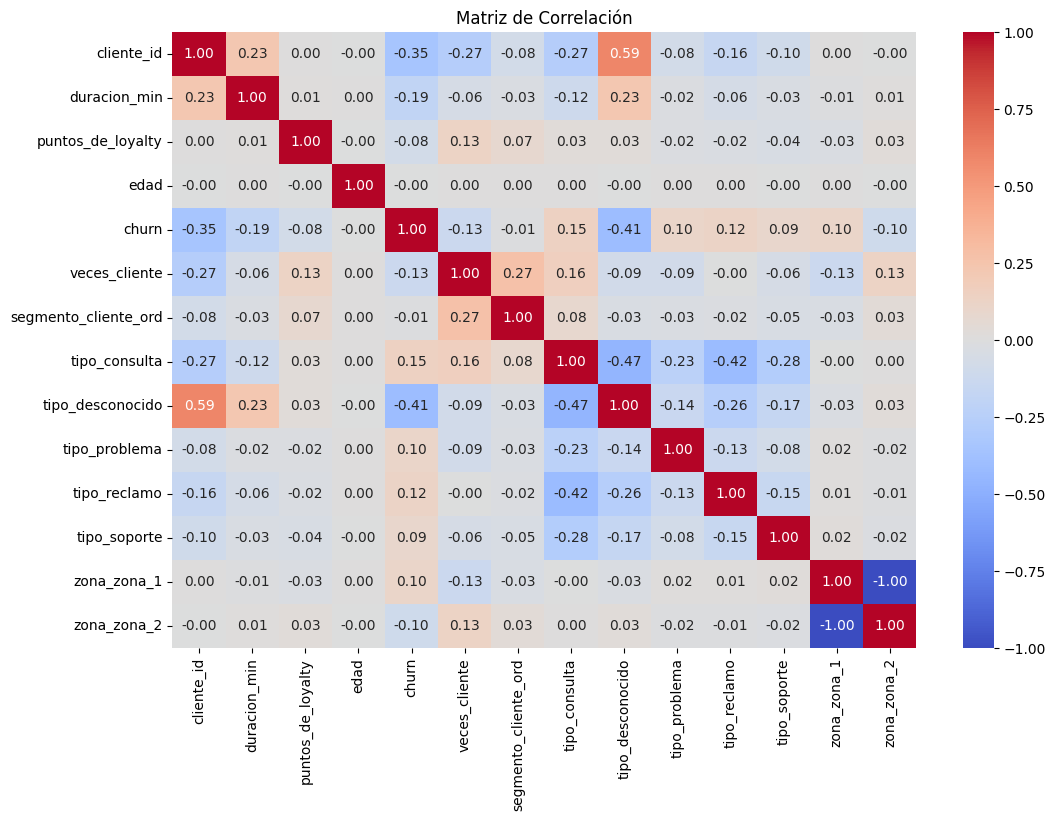

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# 1) Tomar numéricas + booleanas
df_corr = df_resultado.select_dtypes(include=['number', 'bool']).copy()

# 2) Castear SOLO las booleanas a int
bool_cols = df_corr.select_dtypes(include='bool').columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)



# 3) Heatmap
plt.figure(figsize=(12, 8))
corr = df_corr.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación')
plt.show()


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TARGET = 'churn'   # <-- tu target
TOP = 25           # cuántas features mostrar



# 1) Tomar numéricas + booleanas y castear bool->int
X = df_resultado.select_dtypes(include=['number', 'bool']).copy()
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# 2) Quitar columnas constantes (evita NaN en correlaciones)
X = X.loc[:, X.nunique(dropna=False) > 1]

if TARGET not in X.columns:
    raise ValueError(f"'{TARGET}' no está en las columnas numéricas/bool.")

# 3) Correlación con el target (Pearson). Si preferís monotónica: method='spearman'
corr_s = X.corr(numeric_only=True, method='pearson')[TARGET].drop(TARGET).dropna()

# 4) Ordenar por valor absoluto y quedarnos con el Top N
corr_top = corr_s.reindex(corr_s.abs().sort_values(ascending=False).index).head(TOP)



# tabla ordenada
tabla = (corr_top.rename('corr')
         .to_frame()
         .assign(abs=lambda d: d['corr'].abs()))

print('Top correlaciones con el target:')
print(tabla)


Top correlaciones con el target:
                          corr       abs
tipo_desconocido     -0.412282  0.412282
cliente_id           -0.348070  0.348070
duracion_min         -0.188178  0.188178
tipo_consulta         0.146489  0.146489
veces_cliente        -0.130426  0.130426
tipo_reclamo          0.122154  0.122154
tipo_problema         0.104908  0.104908
zona_zona_1           0.103966  0.103966
zona_zona_2          -0.103966  0.103966
tipo_soporte          0.089066  0.089066
puntos_de_loyalty    -0.081605  0.081605
segmento_cliente_ord -0.014525  0.014525
edad                 -0.001163  0.001163


## Comenzamos las pruebas de modelos

In [21]:
import time
from sklearn.model_selection import train_test_split
# Modelos
from sklearn import ensemble, linear_model, neighbors, svm, tree, discriminant_analysis, neural_network, naive_bayes
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [22]:
# Armo grupos de test y train
TARGET = 'churn'  

# 1) Tomar numéricas + booleanas
df_numerico = df_resultado.select_dtypes(include=['number', 'bool']).copy()

# 2) Castear SOLO las booleanas a int
bool_cols = df_numerico.select_dtypes(include='bool').columns
df_numerico[bool_cols] = df_numerico[bool_cols].astype(int)

X = df_numerico.drop(columns=[TARGET])
y = df_numerico[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# Lista de modelos


MLA = [
    ## Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.HistGradientBoostingClassifier(),

    ## Boosting externos
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0),

    ## GLM
    linear_model.LogisticRegression(max_iter=1000),
    # linear_model.LogisticRegressionCV(max_iter=1000),
    linear_model.RidgeClassifier(),
    # linear_model.SGDClassifier(),

    # ## Nearest Neighbor
    # neighbors.KNeighborsClassifier(),
    # neighbors.RadiusNeighborsClassifier(radius=5.0),

    ## SVM
    # svm.SVC(),
    # svm.LinearSVC(max_iter=10000),
    # svm.NuSVC(),

    ## Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # ## Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # ## Naive Bayes
    # naive_bayes.GaussianNB(),
    # naive_bayes.MultinomialNB(),
    # naive_bayes.BernoulliNB(),
    # naive_bayes.ComplementNB(),

    ## Neural Network (shallow MLP)
    # neural_network.MLPClassifier(
    #     hidden_layer_sizes=(100,),
    #     activation='relu',
    #     solver='adam',
    #     max_iter=300,
    #     random_state=42
    # )
]


# Tabla de comparación
MLA_columns = [
    'MLA Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1 Score',
    'Tasa de mala clasificacion',
    'Tiempo'
]
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = pd.DataFrame()
MLA_test = pd.DataFrame()

# Loop de entrenamiento y evaluación
row_index = 0
for alg in MLA:
    inicio = time.time()
    
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name

    alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)

    # Métricas
    MLA_compare.loc[row_index, 'Accuracy'] = round(accuracy_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'F1 Score'] = round(f1_score(y_test, y_pred), 3)
    MLA_compare.loc[row_index, 'Tasa de mala clasificacion'] = round(1 - accuracy_score(y_test, y_pred), 3)

    fin = time.time()
    MLA_compare.loc[row_index, 'Tiempo'] = round(fin - inicio, 2)

    # Predicciones para análisis
    MLA_predict[MLA_name] = alg.predict(X_train)
    MLA_test[MLA_name] = y_pred

    row_index += 1

# Ordenar por precisión
MLA_compare.sort_values(by='Accuracy', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 182414, number of negative: 55894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 238308, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.765455 -> initscore=1.182822
[LightGBM] [Info] Start training from score 1.182822


c:\Users\Ithreex Global\Downloads\challenge-mlops\venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
MLA_compare

,MLA Name,Accuracy,Precision,Recall,F1 Score,Tasa de mala clasificacion,Tiempo
5,HistGradientBoostingClassifier,0.877,0.902,0.942,0.921,0.123,4.04
7,LGBMClassifier,0.877,0.902,0.942,0.921,0.123,1.44
6,XGBClassifier,0.876,0.903,0.94,0.921,0.124,0.8
8,CatBoostClassifier,0.876,0.903,0.939,0.921,0.124,29.7
3,GradientBoostingClassifier,0.871,0.891,0.948,0.918,0.129,71.27
4,RandomForestClassifier,0.866,0.894,0.937,0.915,0.134,38.93
2,ExtraTreesClassifier,0.864,0.889,0.939,0.913,0.136,31.3
1,BaggingClassifier,0.857,0.907,0.906,0.906,0.143,21.0
0,AdaBoostClassifier,0.835,0.855,0.944,0.897,0.165,15.6
11,DecisionTreeClassifier,0.833,0.892,0.89,0.891,0.167,1.88
